# Проект: классификация

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import cross_val_score
import optuna

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Знакомство с данными.

In [2]:
df = pd.read_csv('F:\IDE\SkillFactory\Проекты\Проект 4\\bank_fin.csv', sep = ';')
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,"1,00 $",yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,"733,00 $",no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,"29,00 $",no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0 $,no,yes,cellular,8,may,9,2,172,5,failure,no


Данные о клиентах банка:

* age (возраст);
* job (сфера занятости);
* marital (семейное положение);
* education (уровень образования);
* default (имеется ли просроченный кредит);
* housing (имеется ли кредит на жильё);
* loan (имеется ли кредит на личные нужды);
* balance (баланс).

Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:

* contact (тип контакта с клиентом);
* month (месяц, в котором был последний контакт);
* day (день, в который был последний контакт);
* duration (продолжительность контакта в секундах).

Прочие признаки:

* campaign (количество контактов с этим клиентом в течение текущей кампании);
* pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
* previous (количество контактов до текущей кампании)
* poutcome (результат прошлой маркетинговой кампании).

**Целевая переменная** - *deposit*, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

### Обработка пропусков.

In [3]:
# Определяем пропуски в данных:
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

Признак 'balance' содержит 25 пропусков.

Посмотрим на статистику по каждому из признаков.

In [4]:
df.describe(include='all')

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
count,11162.000000,11162,11162,11162,11162,11137,11162,11162,11162,11162.000000,11162,11162.000000,11162.000000,11162.000000,11162.000000,11162,11162
unique,NaN,12,3,4,2,3802,2,2,3,NaN,12,NaN,NaN,NaN,NaN,4,2
top,NaN,management,married,secondary,no,0 $,no,no,cellular,NaN,may,NaN,NaN,NaN,NaN,unknown,no
freq,NaN,2566,6351,5476,10994,774,5881,9702,8042,NaN,2824,NaN,NaN,NaN,NaN,8326,5873
mean,41.231948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.658036,NaN,371.993818,2.508421,51.330407,0.832557,NaN,NaN
std,11.913369,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.420740,NaN,347.128386,2.722077,108.758282,2.292007,NaN,NaN
min,18.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,2.000000,1.000000,-1.000000,0.000000,NaN,NaN
25%,32.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.000000,NaN,138.000000,1.000000,-1.000000,0.000000,NaN,NaN
50%,39.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.000000,NaN,255.000000,2.000000,-1.000000,0.000000,NaN,NaN
75%,49.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.000000,NaN,496.000000,3.000000,20.750000,1.000000,NaN,NaN


Как видим, помимо явных пропусков, в данных есть ячейки со значением 'unknown'. Определим все признаки, содержащие данные значения.

In [5]:
# Создадим список, в который будем вносить названия столбцов:
cols_with_unknown = []
# Проверим все столбцы на содержание в них значения 'unknown':
for col in df.columns:
    if df[col].isin(['unknown']).any():
        cols_with_unknown.append(col)
    else:
        None
# Выведем на экран список полученных столбцов:
cols_with_unknown

['job', 'education', 'contact', 'poutcome']

Итак, в признаках 'job', 'education', 'contact', 'poutcome' есть скрытые пропуски, т.е. ячейки со значением 'unknown'.

In [6]:
# Создадим копию датасета:
df_copy = df.copy()

Приведём признак 'balance' к типу 'float'.

In [7]:
# Удаляем из признака 'balance' все лишние символы:
df_copy['balance'] = df_copy['balance'].str.replace('$', '')
df_copy['balance'] = df_copy['balance'].str.replace(',', '.')
df_copy['balance'] = df_copy['balance'].str.replace(' ', '')

# Приводим к типу float:
df_copy['balance'] = df_copy['balance'].astype(float)
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        11162 non-null  int64  
 1   job        11162 non-null  object 
 2   marital    11162 non-null  object 
 3   education  11162 non-null  object 
 4   default    11162 non-null  object 
 5   balance    11137 non-null  float64
 6   housing    11162 non-null  object 
 7   loan       11162 non-null  object 
 8   contact    11162 non-null  object 
 9   day        11162 non-null  int64  
 10  month      11162 non-null  object 
 11  duration   11162 non-null  int64  
 12  campaign   11162 non-null  int64  
 13  pdays      11162 non-null  int64  
 14  previous   11162 non-null  int64  
 15  poutcome   11162 non-null  object 
 16  deposit    11162 non-null  object 
dtypes: float64(1), int64(6), object(10)
memory usage: 1.4+ MB


Заполним пропуски в признаке 'balance' медианным значением.

In [8]:
df_copy['balance'] = df_copy['balance'].fillna(df_copy['balance'].median())
round(df_copy['balance'].mean(), 3)

1526.936

Теперь заполним пропуски в признаках 'job', 'education' модальными значениями.

In [9]:
df_copy['job'] = df_copy['job'].apply(lambda x: df_copy['job'].mode()[0] if x == 'unknown' else x)
df_copy['education'] = df_copy['education'].apply(lambda x: df_copy['education'].mode()[0] if x == 'unknown' else x)

### Обработка выбросов.

Определим границы поиска выбросов по методу Тьюки.

In [10]:
# Составим функцию для вычисления выбросов по методу Тьюки.
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned, lower_bound, upper_bound

# Применим эту функцию к признаку 'balance', а также выведем размерности результатов:
outliers, cleaned, lower_bound, upper_bound = outliers_iqr(df_copy, 'balance')
print(f'Нижняя граница выбросов равна: {lower_bound}')
print(f'Верхняя граница выбросов равна: {upper_bound}')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Нижняя граница выбросов равна: -2241.0
Верхняя граница выбросов равна: 4063.0
Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105


Удалим выбросы.

In [11]:
df_copy = df_copy[(df_copy['balance'] > lower_bound) & (df_copy['balance'] < upper_bound)]
df_copy

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1.0,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,733.0,no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,29.0,no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0.0,no,yes,cellular,8,may,9,2,172,5,failure,no


## Часть 2:  Разведывательный анализ

Проведём исследование признака 'deposit'.

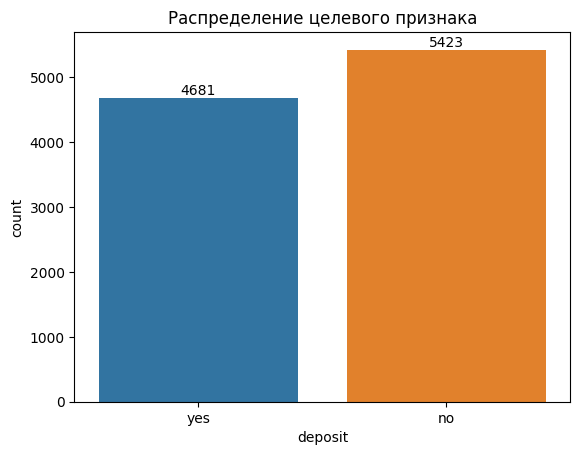

In [12]:
ax = sns.countplot(df_copy, x = "deposit")
ax.bar_label(ax.containers[0], fontsize=10)
ax.set_title("Распределение целевого признака");

Целевая переменная сбалансировна.

Проведём визуализацию и анализ числовых признаков.

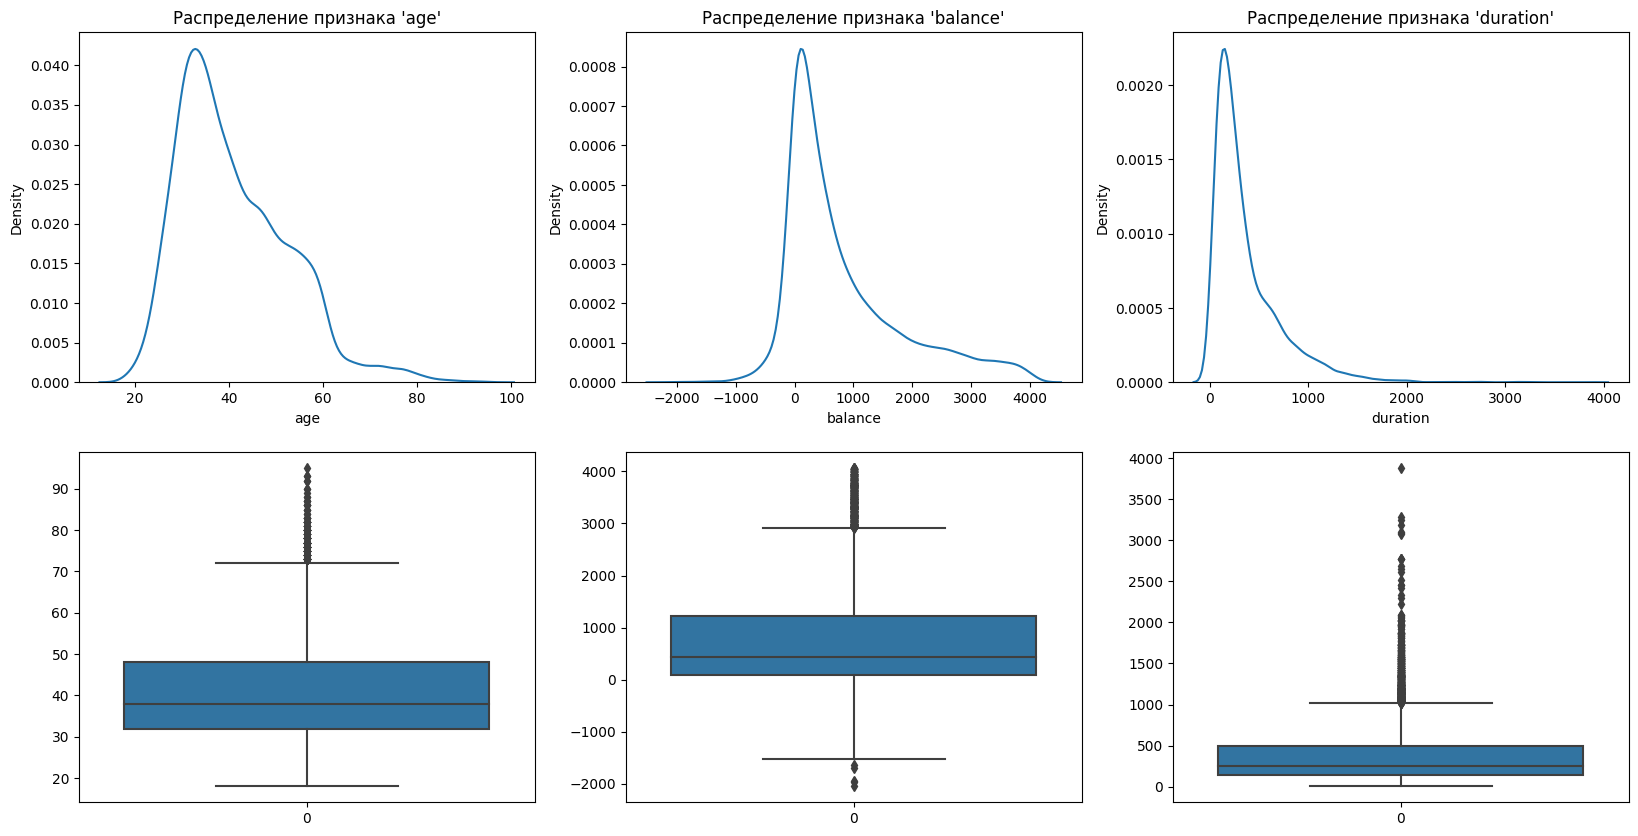

In [13]:
# Построим диаграммы распределения KDE и коробчатые диаграммы для числовых признаков:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize = (20, 10))

ax1 = sns.kdeplot(df_copy['age'], ax=axes[0, 0])
ax1.set_title("Распределение признака 'age'")
ax2 = sns.kdeplot(df_copy['balance'], ax=axes[0, 1])
ax2.set_title("Распределение признака 'balance'")
ax3 = sns.kdeplot(df_copy['duration'], ax=axes[0, 2])
ax3.set_title("Распределение признака 'duration'")
ax4 = sns.boxplot(df_copy['age'], ax=axes[1, 0])
ax5 = sns.boxplot(df_copy['balance'], ax=axes[1, 1])
ax6 = sns.boxplot(df_copy['duration'], ax=axes[1, 2])

Числовые признаки распределены ненормально. Есть много выбросов.

In [14]:
# Выведем основную статистику для числовых признаков:
numeric_features = ['age', 'balance', 'duration']
df_copy[numeric_features].describe()

,age,balance,duration
count,10104.000000,10104.000000,10104.000000
mean,40.895487,807.331354,368.777712
std,11.735511,993.673452,346.650712
min,18.000000,-2049.000000,2.000000
25%,32.000000,95.000000,137.000000
50%,38.000000,444.500000,252.000000
75%,48.000000,1224.750000,490.000000
max,95.000000,4062.000000,3881.000000


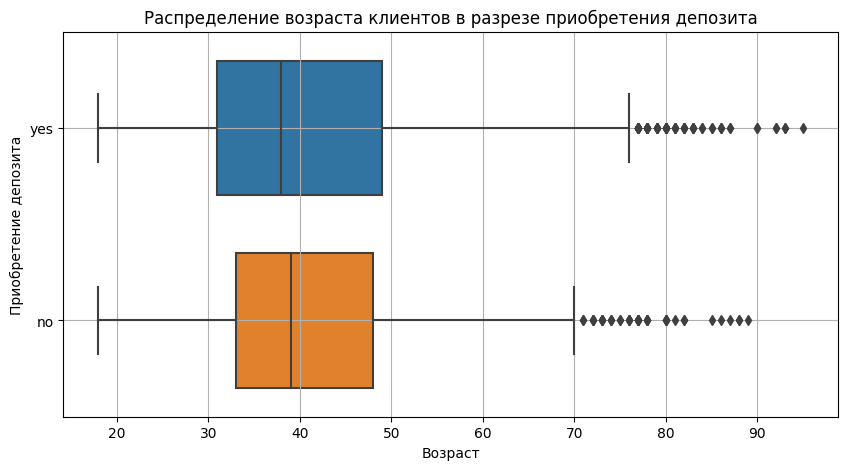

In [15]:
# Построим коробчатую диаграмму распределения возраста клиентов в разрезе приобретения депозита:
fig1 = plt.figure(figsize=(10, 5))
age_deposit = sns.boxplot( 
    data=df_copy,
    x='age',
    y='deposit',
    orient='h',
    width=0.7
)
age_deposit.set_title('Распределение возраста клиентов в разрезе приобретения депозита')
age_deposit.set_xlabel('Возраст')
age_deposit.set_ylabel('Приобретение депозита')
age_deposit.grid()

Распределение клентов, согласившихся и отказавшихся от депозита, по возрасту примерно равно. 

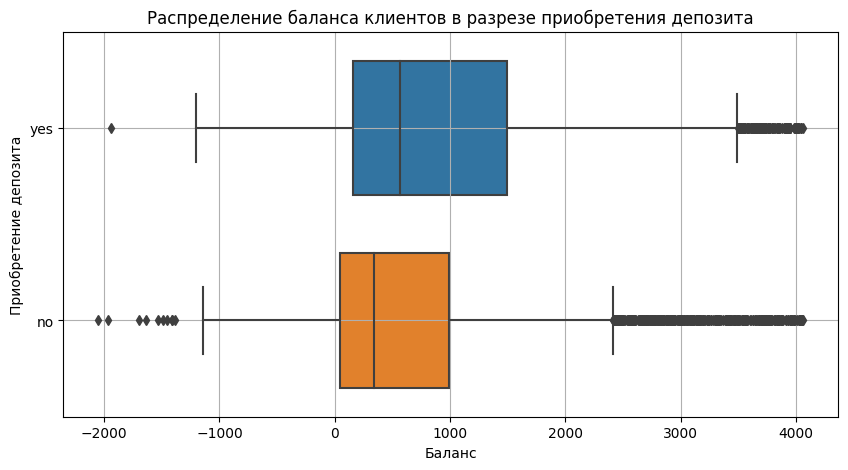

In [16]:
# Построим коробчатую диаграмму распределения баланса клиентов в разрезе приобретения депозита:
fig2 = plt.figure(figsize=(10, 5))
balance_deposit = sns.boxplot( 
    data=df_copy,
    x='balance',
    y='deposit',
    orient='h',
    width=0.7
)
balance_deposit.set_title('Распределение баланса клиентов в разрезе приобретения депозита')
balance_deposit.set_xlabel('Баланс')
balance_deposit.set_ylabel('Приобретение депозита')
balance_deposit.grid()

У клиентов, согласившихся на депозит, баланс на счету выше, чем у отказавшихся.

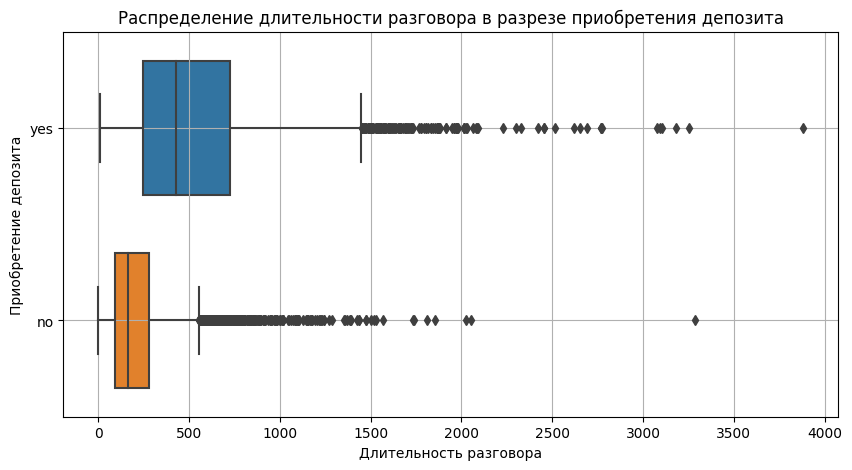

In [17]:
# Построим коробчатую диаграмму распределения длительности разговора в разрезе приобретения депозита:
fig3 = plt.figure(figsize=(10, 5))
duration_deposit = sns.boxplot( 
    data=df_copy,
    x='duration',
    y='deposit',
    orient='h',
    width=0.7
)
duration_deposit.set_title('Распределение длительности разговора в разрезе приобретения депозита')
duration_deposit.set_xlabel('Длительность разговора')
duration_deposit.set_ylabel('Приобретение депозита')
duration_deposit.grid()

Как видим, люди, согласившиеся в дальнейшем на депозит, проявляли свою зпинтересованность уже на стадии телефонных разговоров. Продолжительность этих разговоров у согласившихся на депозит значительно выше, чем у отказавшихся.

Проанализируем категориальные переменные.

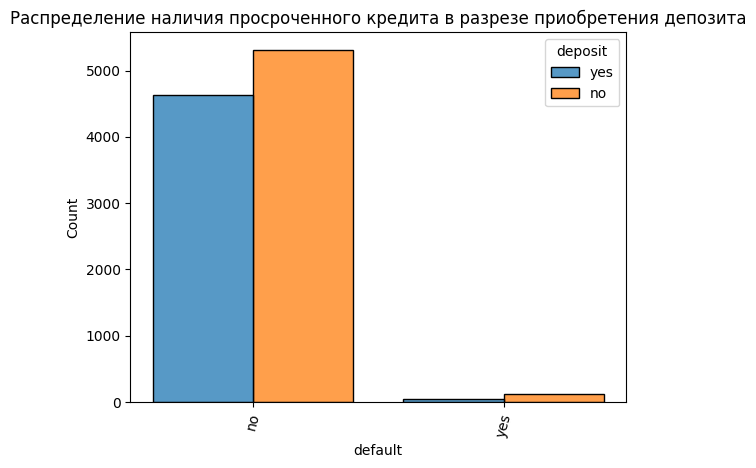

In [19]:
sns.histplot(data=df_copy, x="default", hue="deposit", multiple="dodge", shrink=.8)
plt.xticks(rotation=75)
plt.title('Распределение наличия просроченного кредита в разрезе приобретения депозита');

У подавляющего большинства клиентов нет просроченного кредита. Этот признак не оказывает практически никакого влияния на целевую переменную.

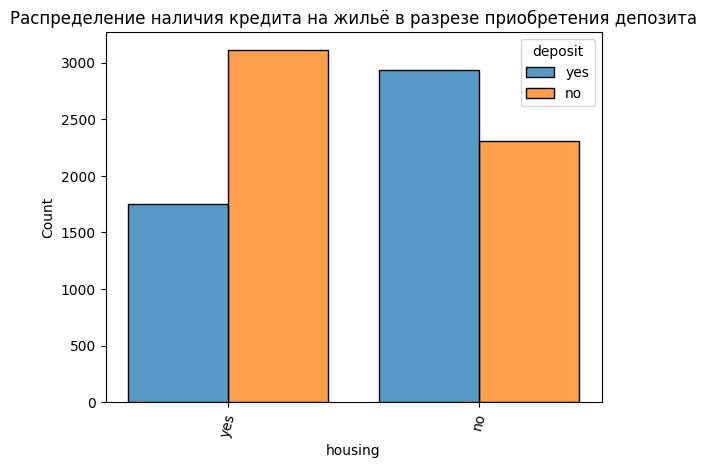

In [20]:
sns.histplot(data=df_copy, x="housing", hue="deposit", multiple="dodge", shrink=.8)
plt.xticks(rotation=75)
plt.title('Распределение наличия кредита на жильё в разрезе приобретения депозита');

Клиенты с редитом на жильё гораздо чаще отказывались от депозита, чем те, у которых такого кредита нет.

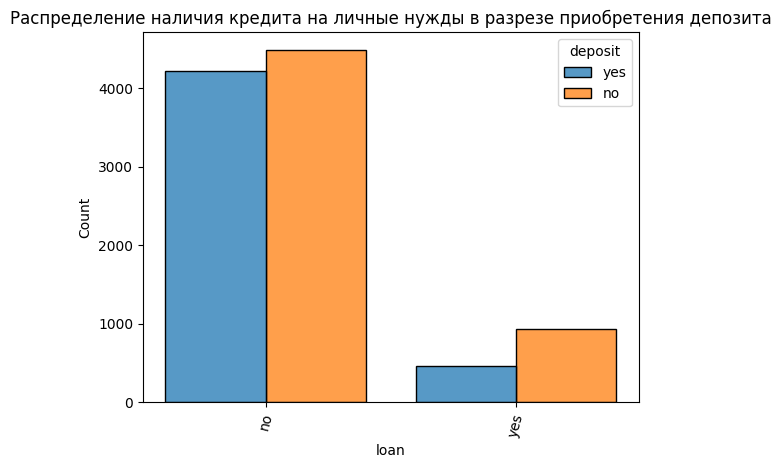

In [21]:
sns.histplot(data=df_copy, x="loan", hue="deposit", multiple="dodge", shrink=.8)
plt.xticks(rotation=75)
plt.title('Распределение наличия кредита на личные нужды в разрезе приобретения депозита');

У подавляющего большинства клиентов нет кредита на личные нужды. Этот признак не оказывает практически никакого влияния на целевую переменную.

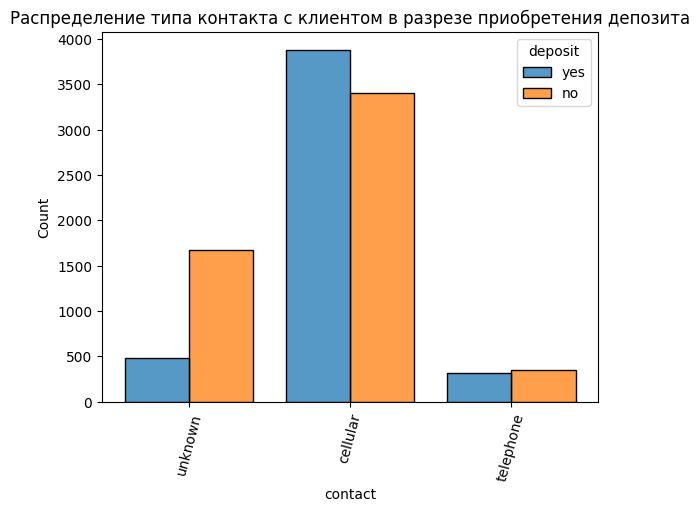

In [22]:
sns.histplot(data=df_copy, x="contact", hue="deposit", multiple="dodge", shrink=.8)
plt.xticks(rotation=75)
plt.title('Распределение типа контакта с клиентом в разрезе приобретения депозита');

С подавляющим большинством клиентов контакт происходил по сотовой связи. Этот признак не оказывает практически никакого влияния на целевую переменную.

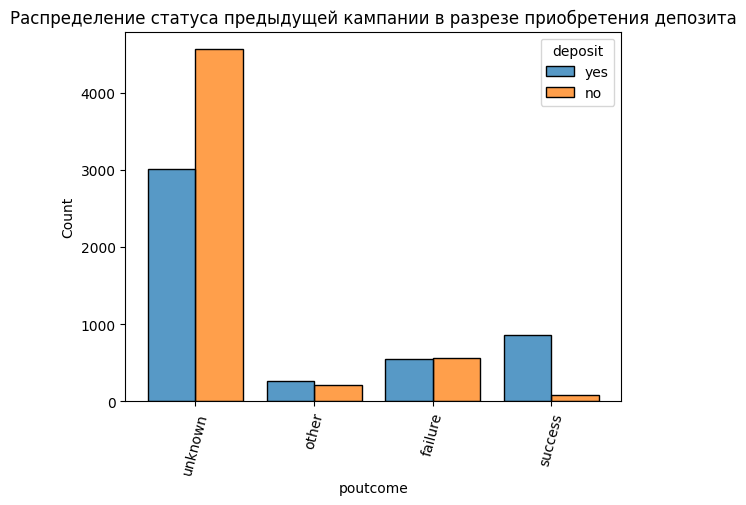

In [23]:
sns.histplot(data=df_copy, x="poutcome", hue="deposit", multiple="dodge", shrink=.8)
plt.xticks(rotation=75)
plt.title('Распределение статуса предыдущей кампании в разрезе приобретения депозита');

Как видим, успешность предыдущей кампании оказывала влияние на факт приобретения депозита.

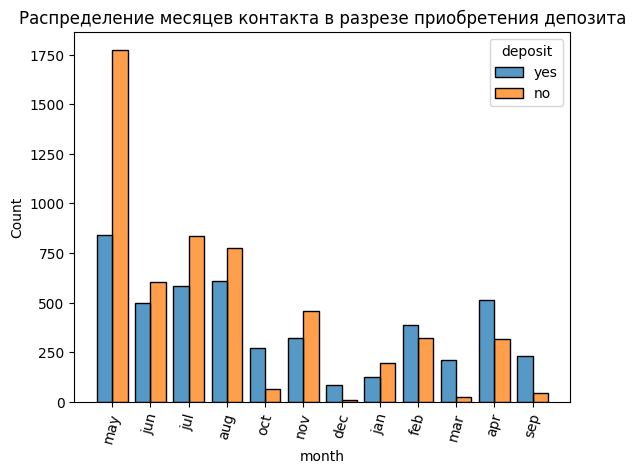

In [24]:
sns.histplot(data=df_copy, x="month", hue="deposit", multiple="dodge", shrink=.8)
plt.xticks(rotation=75)
plt.title('Распределение месяцев контакта в разрезе приобретения депозита');

На данном графике обращает на себя внимание тот факт, что в мае было получено значительное число отказов от депозита. Число согласий на депозит превосходило число отказов в октябре, декабре, феврале, марте, апреле и сентябре.

<AxesSubplot: xlabel='age_group', ylabel='count'>

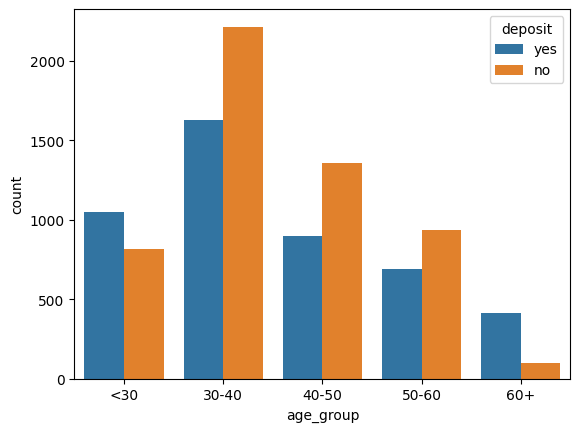

In [25]:
df_copy['age_group'] = pd.cut(df_copy.age, [0,30,40,50,60,9999], labels = ['<30','30-40','40-50','50-60','60+'])
sns.countplot(x="age_group", hue="deposit", data=df_copy)

Число согласий на депозит превосходило число отказов в возрастных категориях до 30 лет и свыше 60.

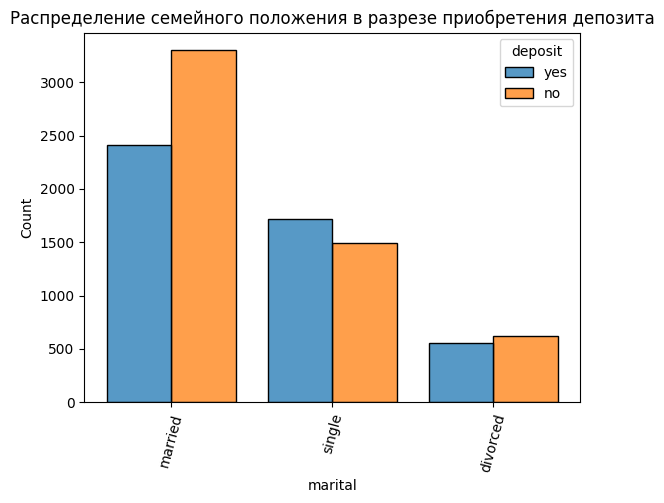

In [26]:
sns.histplot(data=df_copy, x="marital", hue="deposit", multiple="dodge", shrink=.8)
plt.xticks(rotation=75)
plt.title('Распределение семейного положения в разрезе приобретения депозита');

Одинокие люди чаще соглашаются на депозит, чем отказываются от него.

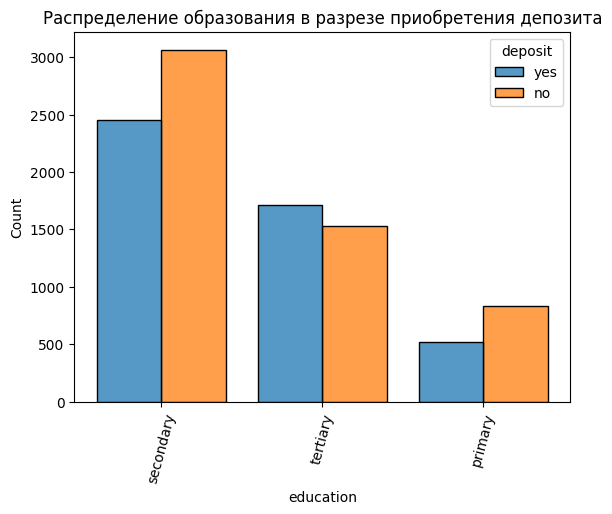

In [27]:
sns.histplot(data=df_copy, x="education", hue="deposit", multiple="dodge", shrink=.8)
plt.xticks(rotation=75)
plt.title('Распределение образования в разрезе приобретения депозита');

Люди с высшим образованием более склонные брать депозит, чем отказыватьяс от него.

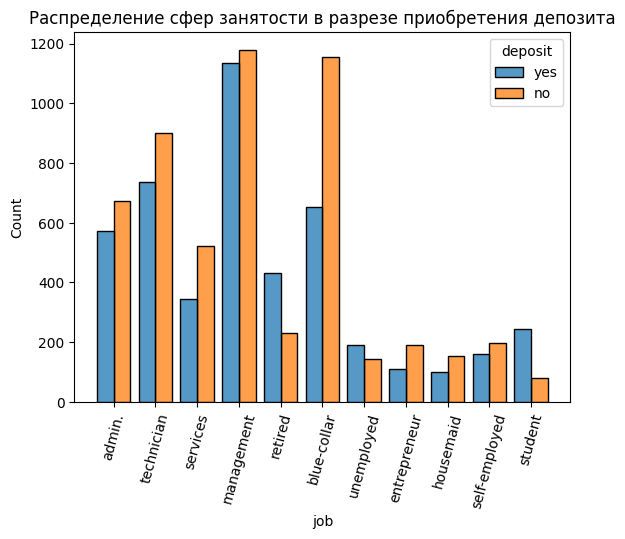

In [28]:
sns.histplot(data=df_copy, x="job", hue="deposit", multiple="dodge", shrink=.8)
plt.xticks(rotation=75)
plt.title('Распределение сфер занятости в разрезе приобретения депозита');

Более склонны к депозитам пенсионеры, безработные и студенты. Среди "синих воротничков" отказы от депозита значительно превосходят согласия на него. В абсолютном же исчислении согласий на депозит больше всего среди управляющих, "технарей" и "синих воротничков".

Попробуем определить, зависит ли факт согласия на депозит от уровня образования и семейного положения.

Отфильтруем клиентов в зависимости от согласия/несогласия на депозит.

In [29]:
# Таблица с согласившимися на депозит.
deposit_yes = df_copy[df_copy['deposit'] == 'yes']
deposit_yes

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,50-60
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,50-60
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,40-50
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,50-60
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes,50-60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5284,78,retired,divorced,primary,no,1389.0,no,no,cellular,8,apr,335,1,-1,0,unknown,yes,60+
5285,30,management,single,tertiary,no,398.0,no,no,cellular,27,oct,102,1,180,3,success,yes,<30
5286,69,retired,divorced,tertiary,no,247.0,no,no,cellular,22,apr,138,2,-1,0,unknown,yes,60+
5287,48,entrepreneur,married,secondary,no,0.0,no,yes,cellular,28,jul,431,2,-1,0,unknown,yes,40-50


In [30]:
# Таблица с несогласившимися на депозит.
deposit_no = df_copy[df_copy['deposit'] == 'no']
deposit_no

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
5289,57,retired,single,primary,no,604.0,no,no,cellular,19,nov,187,1,-1,0,unknown,no,50-60
5290,45,admin.,divorced,secondary,no,0.0,yes,no,cellular,17,nov,102,1,-1,0,unknown,no,40-50
5291,48,blue-collar,married,secondary,no,238.0,yes,yes,cellular,2,jun,118,2,81,1,success,no,40-50
5292,34,admin.,single,secondary,no,673.0,yes,no,cellular,29,jan,89,1,260,2,failure,no,30-40
5294,32,management,married,tertiary,no,3696.0,no,no,unknown,21,may,315,3,-1,0,unknown,no,30-40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1.0,yes,no,cellular,20,apr,257,1,-1,0,unknown,no,30-40
11158,39,services,married,secondary,no,733.0,no,no,unknown,16,jun,83,4,-1,0,unknown,no,30-40
11159,32,technician,single,secondary,no,29.0,no,no,cellular,19,aug,156,2,-1,0,unknown,no,30-40
11160,43,technician,married,secondary,no,0.0,no,yes,cellular,8,may,9,2,172,5,failure,no,40-50


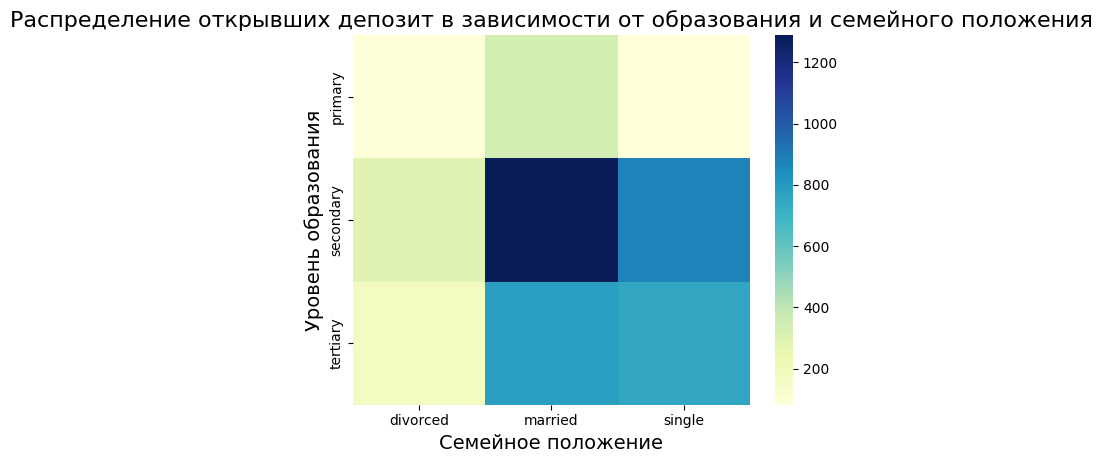

In [31]:
pivot_yes = deposit_yes.pivot_table( # Строим сводную таблицу по семейному положению и уровню образования.
    values='deposit',
    index='education',
    columns='marital',
    aggfunc='count'
)

heatmap = sns.heatmap(data=pivot_yes, cmap='YlGnBu') # На основе сводной таблицы строим тепловую карту.
heatmap.set_title('Распределение открывших депозит в зависимости от образования и семейного положения', fontsize=16)
heatmap.set_xlabel('Семейное положение', fontsize=14)
heatmap.set_ylabel('Уровень образования', fontsize=14);

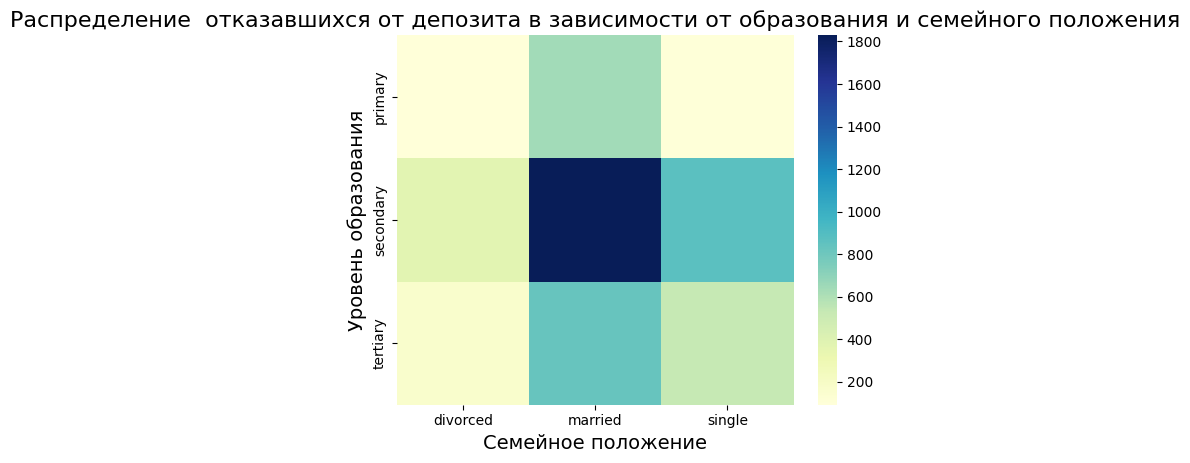

In [32]:
pivot_no = deposit_no.pivot_table( # Строим сводную таблицу по семейному положению и уровню образования.
    values='deposit',
    index='education',
    columns='marital',
    aggfunc='count'
)

heatmap = sns.heatmap(data=pivot_no, cmap='YlGnBu') # На основе сводной таблицы строим тепловую карту.
heatmap.set_title('Распределение  отказавшихся от депозита в зависимости от образования и семейного положения', fontsize=16)
heatmap.set_xlabel('Семейное положение', fontsize=14)
heatmap.set_ylabel('Уровень образования', fontsize=14);

Как среди согласившихся, так и среди отказавшихся от депозита превалируют семейные люди со средним образованием. Однако можно заметить, что среди согласившихся на депозит доля одиноких и людей с высшим образованием выше.

## Часть 3: преобразование данных

Произведём кодирование категориальных признаков.

In [33]:
# Создание экземпляра класса LabelEncoder()
lab_enc = LabelEncoder()

# Кодирование признака 'education'
df_copy['education'] = lab_enc.fit_transform(df_copy['education'])
df_copy['education'].sum()

11993

In [34]:
# Создание экземпляра класса LabelEncoder()
lab_enc = LabelEncoder()

# Кодирование признака 'age_group'
df_copy['age_group'] = lab_enc.fit_transform(df_copy['age_group'])
df_copy

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,59,admin.,married,1,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,2
1,56,admin.,married,1,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,2
2,41,technician,married,1,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,1
3,55,services,married,1,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,2
4,54,admin.,married,2,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,0,no,1.0,yes,no,cellular,20,apr,257,1,-1,0,unknown,no,0
11158,39,services,married,1,no,733.0,no,no,unknown,16,jun,83,4,-1,0,unknown,no,0
11159,32,technician,single,1,no,29.0,no,no,cellular,19,aug,156,2,-1,0,unknown,no,0
11160,43,technician,married,1,no,0.0,no,yes,cellular,8,may,9,2,172,5,failure,no,1


In [35]:
# Кодируем бинарные признаки:
df_copy['deposit'] = df_copy['deposit'].apply(lambda x: 1 if x == 'yes' else 0)
df_copy['default'] = df_copy['default'].apply(lambda x: 1 if x == 'yes' else 0)
df_copy['housing'] = df_copy['housing'].apply(lambda x: 1 if x == 'yes' else 0)
df_copy['loan'] = df_copy['loan'].apply(lambda x: 1 if x == 'yes' else 0)
df_copy

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,59,admin.,married,1,0,2343.0,1,0,unknown,5,may,1042,1,-1,0,unknown,1,2
1,56,admin.,married,1,0,45.0,0,0,unknown,5,may,1467,1,-1,0,unknown,1,2
2,41,technician,married,1,0,1270.0,1,0,unknown,5,may,1389,1,-1,0,unknown,1,1
3,55,services,married,1,0,2476.0,1,0,unknown,5,may,579,1,-1,0,unknown,1,2
4,54,admin.,married,2,0,184.0,0,0,unknown,5,may,673,2,-1,0,unknown,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,0,0,1.0,1,0,cellular,20,apr,257,1,-1,0,unknown,0,0
11158,39,services,married,1,0,733.0,0,0,unknown,16,jun,83,4,-1,0,unknown,0,0
11159,32,technician,single,1,0,29.0,0,0,cellular,19,aug,156,2,-1,0,unknown,0,0
11160,43,technician,married,1,0,0.0,0,1,cellular,8,may,9,2,172,5,failure,0,1


In [36]:
# Создаём dummy-переменные по номинальным признакам:
df_copy = pd.get_dummies(df_copy, columns=['job', 'marital', 'contact', 'month', 'poutcome'], drop_first=False, dtype=int)
df_copy

,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,1,0,2343.0,1,0,5,1042,1,-1,...,0,0,1,0,0,0,0,0,0,1
1,56,1,0,45.0,0,0,5,1467,1,-1,...,0,0,1,0,0,0,0,0,0,1
2,41,1,0,1270.0,1,0,5,1389,1,-1,...,0,0,1,0,0,0,0,0,0,1
3,55,1,0,2476.0,1,0,5,579,1,-1,...,0,0,1,0,0,0,0,0,0,1
4,54,2,0,184.0,0,0,5,673,2,-1,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,0,0,1.0,1,0,20,257,1,-1,...,0,0,0,0,0,0,0,0,0,1
11158,39,1,0,733.0,0,0,16,83,4,-1,...,1,0,0,0,0,0,0,0,0,1
11159,32,1,0,29.0,0,0,19,156,2,-1,...,0,0,0,0,0,0,0,0,0,1
11160,43,1,0,0.0,0,1,8,9,2,172,...,0,0,1,0,0,0,1,0,0,0


Посмотрим на корреляцию признаков.

<AxesSubplot: >

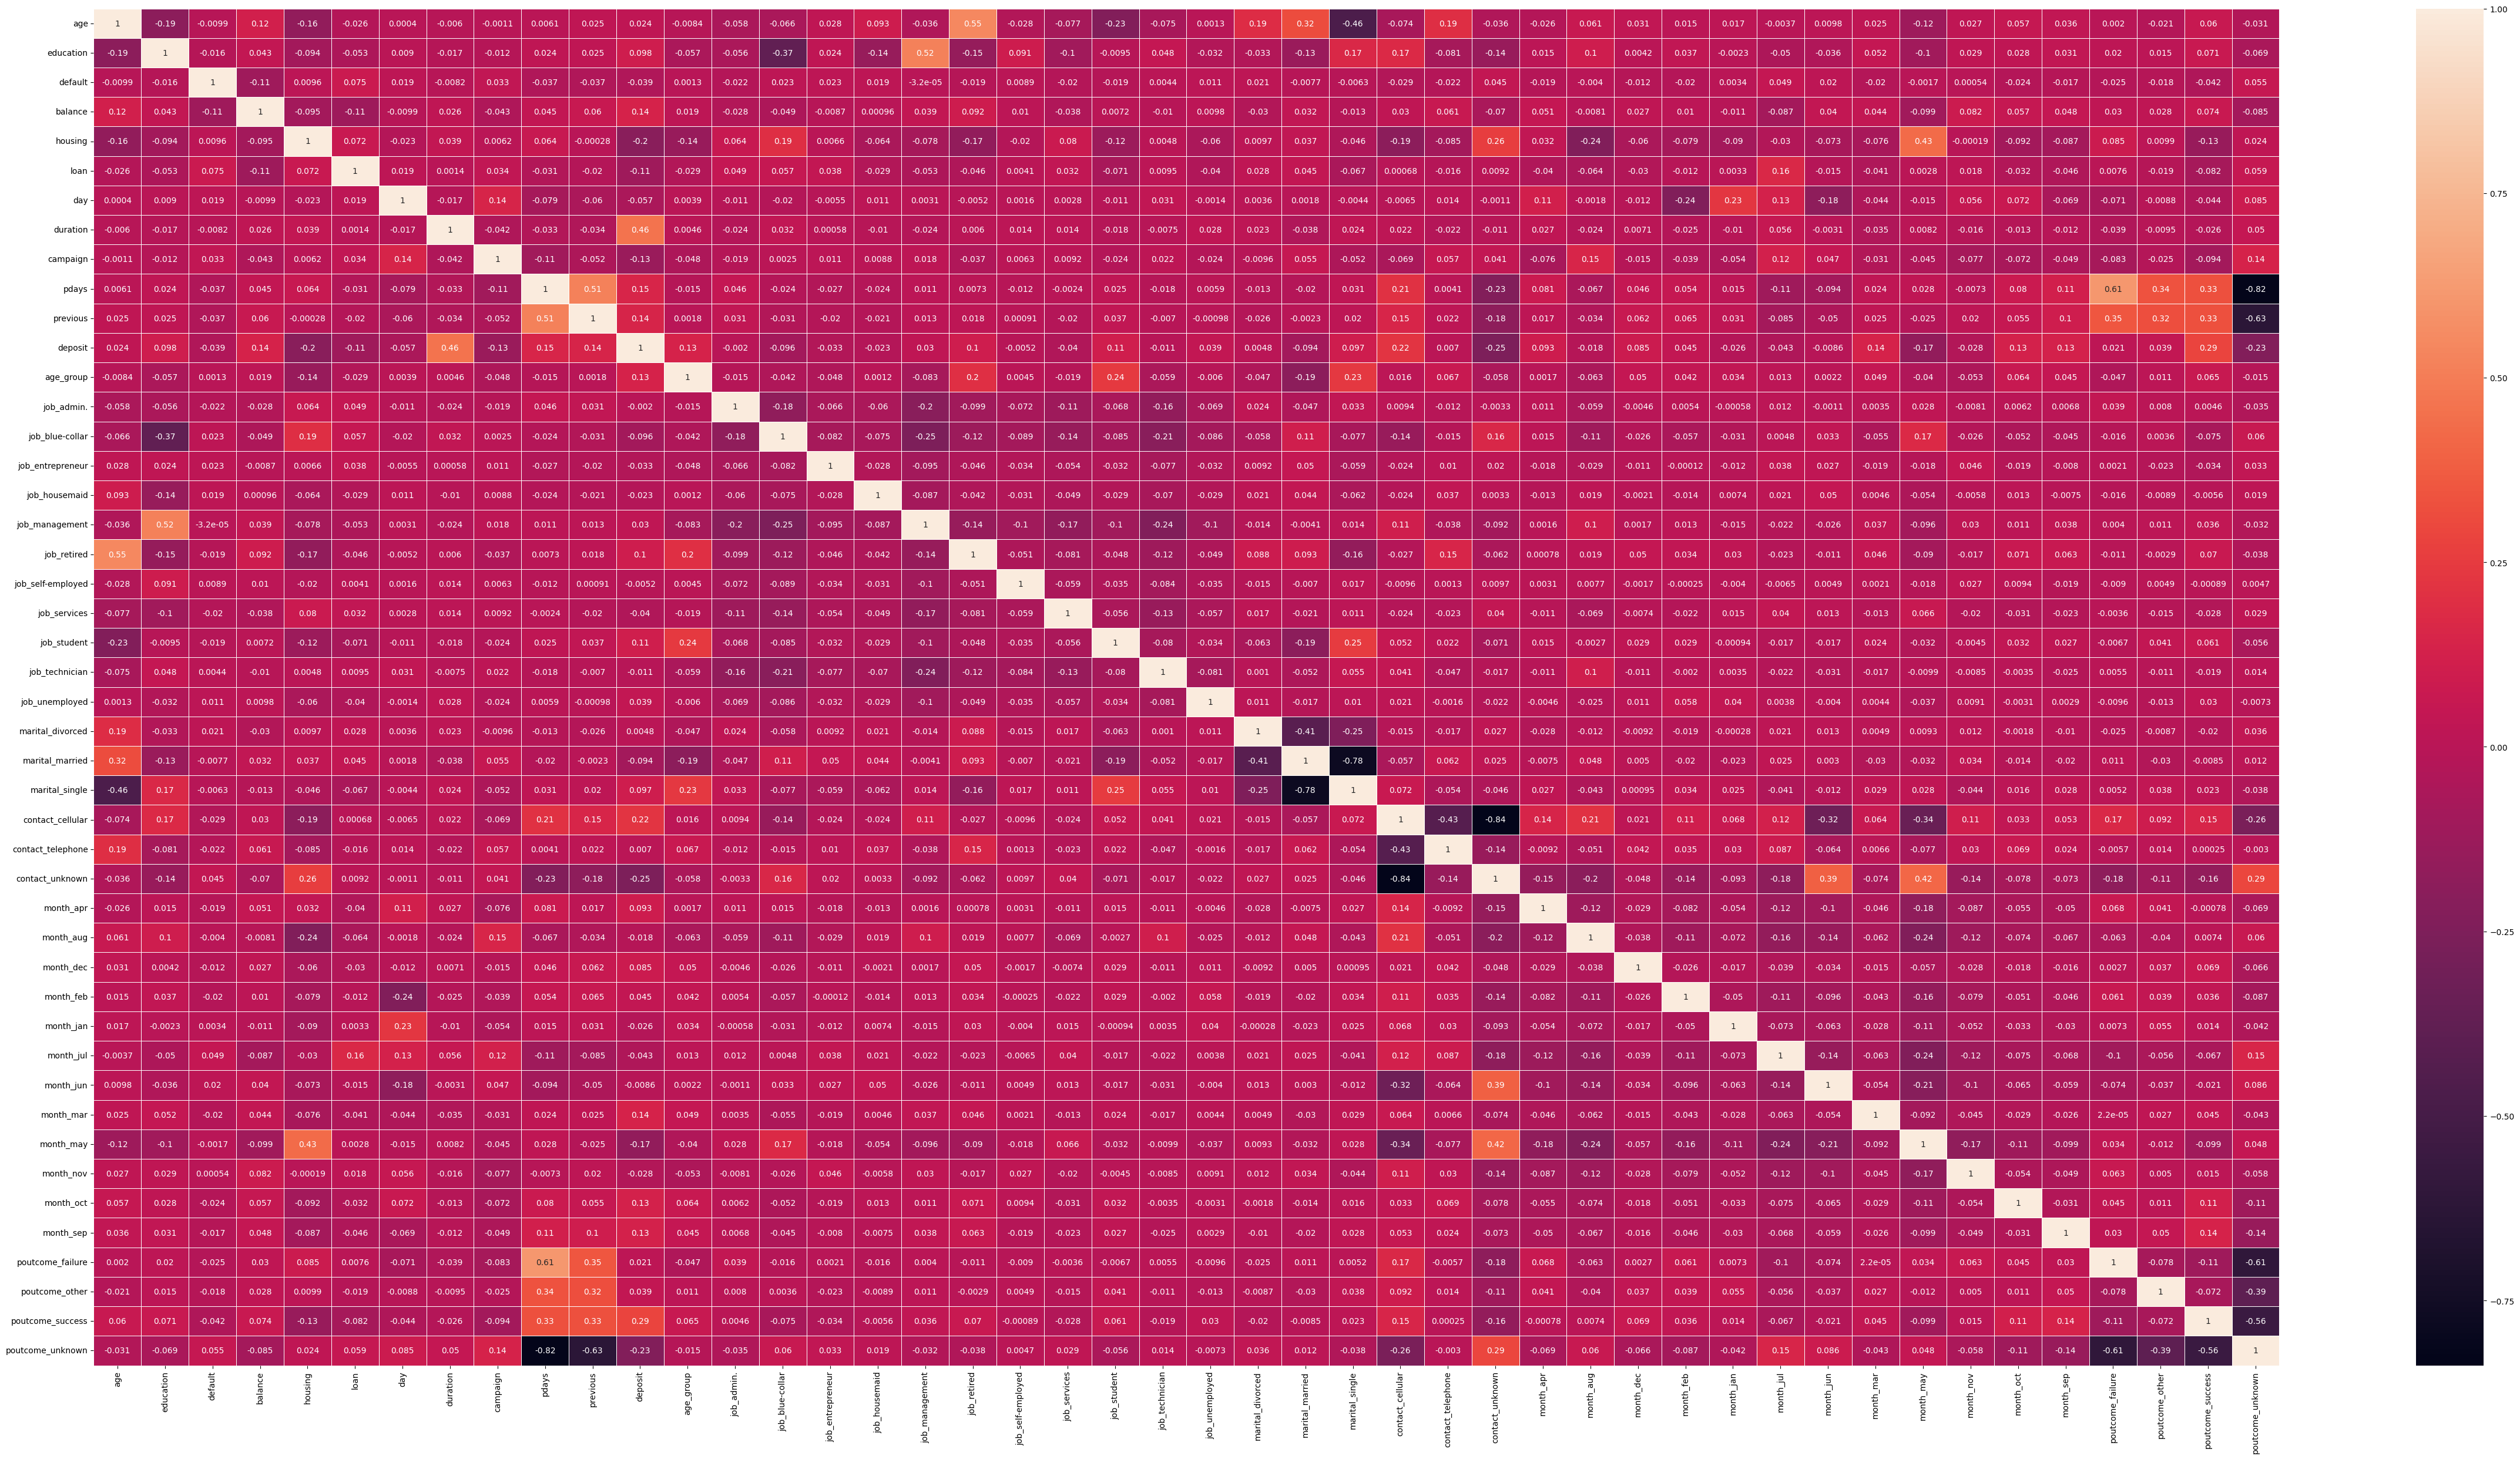

In [37]:
# Составляем тепловую карту корреляции признаков.
fig, ax = plt.subplots(figsize=(60,30))
sns.heatmap(df_copy.corr(), annot=True, linewidths=.5, ax=ax)

In [38]:
# Составляем матрицу корреляций:
corr = df_copy.corr()
corr

,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
age,1.000000,-0.191140,-0.009929,0.115222,-0.164206,-0.026357,0.000396,-0.006007,-0.001144,0.006106,...,0.009770,0.024785,-0.119674,0.026875,0.056998,0.036352,0.001992,-0.020942,0.060009,-0.031458
education,-0.191140,1.000000,-0.015677,0.042870,-0.094491,-0.052520,0.009042,-0.016744,-0.012396,0.023990,...,-0.036462,0.052219,-0.104390,0.028742,0.027642,0.030869,0.019501,0.015132,0.070535,-0.068870
default,-0.009929,-0.015677,1.000000,-0.110946,0.009564,0.074782,0.018719,-0.008176,0.033417,-0.037311,...,0.019621,-0.020030,-0.001739,0.000540,-0.023933,-0.016979,-0.025424,-0.017926,-0.041514,0.055018
balance,0.115222,0.042870,-0.110946,1.000000,-0.095312,-0.113020,-0.009854,0.026127,-0.043010,0.044824,...,0.039888,0.043906,-0.098687,0.081998,0.057131,0.047921,0.030145,0.028198,0.073502,-0.084954
housing,-0.164206,-0.094491,0.009564,-0.095312,1.000000,0.072298,-0.022602,0.038601,0.006164,0.064032,...,-0.073101,-0.075937,0.432515,-0.000190,-0.092012,-0.086880,0.084913,0.009854,-0.134452,0.024265
loan,-0.026357,-0.052520,0.074782,-0.113020,0.072298,1.000000,0.019119,0.001436,0.033927,-0.030747,...,-0.014911,-0.041111,0.002846,0.017708,-0.032364,-0.046203,0.007574,-0.019298,-0.082111,0.059175
day,0.000396,0.009042,0.018719,-0.009854,-0.022602,0.019119,1.000000,-0.016739,0.142215,-0.078716,...,-0.182050,-0.044310,-0.014511,0.056459,0.072172,-0.068752,-0.071084,-0.008816,-0.044381,0.085383
duration,-0.006007,-0.016744,-0.008176,0.026127,0.038601,0.001436,-0.016739,1.000000,-0.042487,-0.032945,...,-0.003097,-0.034658,0.008156,-0.015685,-0.012561,-0.012095,-0.039205,-0.009521,-0.026005,0.050406
campaign,-0.001144,-0.012396,0.033417,-0.043010,0.006164,0.033927,0.142215,-0.042487,1.000000,-0.105325,...,0.046797,-0.030561,-0.044509,-0.077284,-0.071505,-0.048659,-0.082578,-0.024835,-0.094235,0.135025
pdays,0.006106,0.023990,-0.037311,0.044824,0.064032,-0.030747,-0.078716,-0.032945,-0.105325,1.000000,...,-0.093519,0.024210,0.028499,-0.007319,0.079858,0.110932,0.608690,0.338094,0.326271,-0.824014


In [39]:
# Отсортируем признаки по степени корреляции с целевой переменной:
corr["deposit"].apply(lambda x: abs(x)).sort_values()

job_admin.           0.001961
marital_divorced     0.004774
job_self-employed    0.005212
contact_telephone    0.007040
month_jun            0.008565
job_technician       0.011231
month_aug            0.018262
poutcome_failure     0.021396
job_housemaid        0.022587
age                  0.024359
month_jan            0.025865
month_nov            0.027782
job_management       0.029741
job_entrepreneur     0.032724
default              0.038885
job_unemployed       0.039180
poutcome_other       0.039300
job_services         0.040463
month_jul            0.042819
month_feb            0.044704
day                  0.056920
month_dec            0.085036
month_apr            0.092865
marital_married      0.094173
job_blue-collar      0.095893
marital_single       0.096949
education            0.098380
job_retired          0.100071
job_student          0.105550
loan                 0.107282
month_sep            0.125229
month_oct            0.130588
campaign             0.130634
age_group 

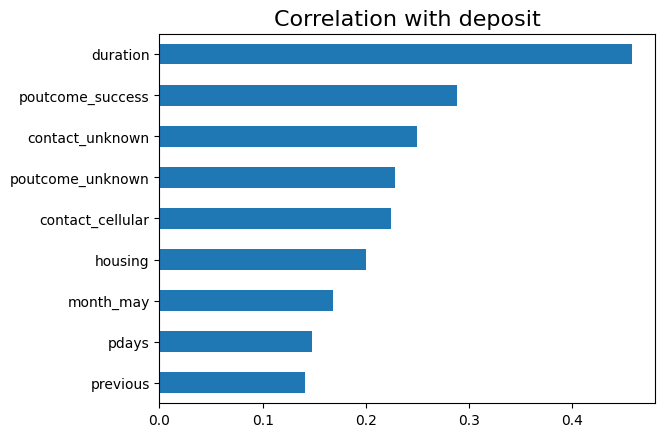

In [40]:
# Топ-10 признаков, наиболее сильно коррелирующих с целевой переменной:
corr["deposit"].apply(lambda x: abs(x)).sort_values()[-10:-1].plot.barh()
plt.title("Correlation with deposit", fontsize = 16)
plt.show()

Мультиколлинеарность с целевой переменной не обнаружена.

Разделим наш датасет на тренировочную и тестовую выборки.

In [41]:
X = df_copy.drop(['deposit'], axis=1)
y = df_copy['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

Отберём 15 признаков, которые наиболее сильно связаны с целевой переменной.

In [42]:
# Используем метод SelectKBest для отбора наиболее важных признаков:
selector = SelectKBest(k=15)
selector.fit(X_train, y_train)
 
selector.get_feature_names_out()

array(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

In [43]:
# Оставим в тренировочной и тестовой выборках только выбранные признаки:
X_train = X_train[selector.get_feature_names_out()]
X_test = X_test[selector.get_feature_names_out()]

Нормализуем данные на тренировочной и тестовой выборках.

In [44]:
# Используем нормализатор MinMaxScaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)                           
X_train_scaled = scaler.transform(X_train)    
X_test_scaled = scaler.transform(X_test)      

print(round(X_test_scaled[:, 0].mean(), 2))

0.47


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

Построим модель на основе логистической регрессии.

In [79]:
log_reg = linear_model.LogisticRegression(
    solver='sag', 
    random_state=42, 
    max_iter=1000 )

# Обучим модель:
log_reg.fit(X_train_scaled, y_train)
# Сделаем предсказание:
y_pred = log_reg.predict(X_test_scaled)
# Выведем метрики accuracy и f1:
print(f'Метрика accuracy равна {round(metrics.accuracy_score(y_test, y_pred), 3)}')
print(f'Метрика f1 равна {round(metrics.f1_score(y_test, y_pred), 3)}')

Метрика accuracy равна 0.809
Метрика f1 равна 0.781


Используем для построения модели метод решающих деревьев

In [80]:
dtc = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42    
)

# Обучим модель:
dtc.fit(X_train_scaled, y_train)
# Сделаем предсказание:
y_pred_test = dtc.predict(X_test_scaled)
y_pred_train = dtc.predict(X_train_scaled)
#Выводим отчёт о метрикe accuracy
print(f'Значение метрики accuracy на тренировочном наборе данных равно {round(metrics.accuracy_score(y_train, y_pred_train), 3)}')
print(f'Значение метрики accuracy на тестовом наборе данных равно {round(metrics.accuracy_score(y_test, y_pred_test), 3)}')

Значение метрики accuracy на тренировочном наборе данных равно 1.0
Значение метрики accuracy на тестовом наборе данных равно 0.76


Значение метрики accuracy на тренировочном наборе данных равно 1.0, а на тестовом она падает. Это явное свидетельство о переобучении модели.

Попробуем подобрать оптимальную глубину деревьев. Оптимальным будем считать такой показатель max_depth, когда метрика accuracy не будет сильно расходиться на тренировочной и тестовой выборках и на тестовой будет при этом максимальной.

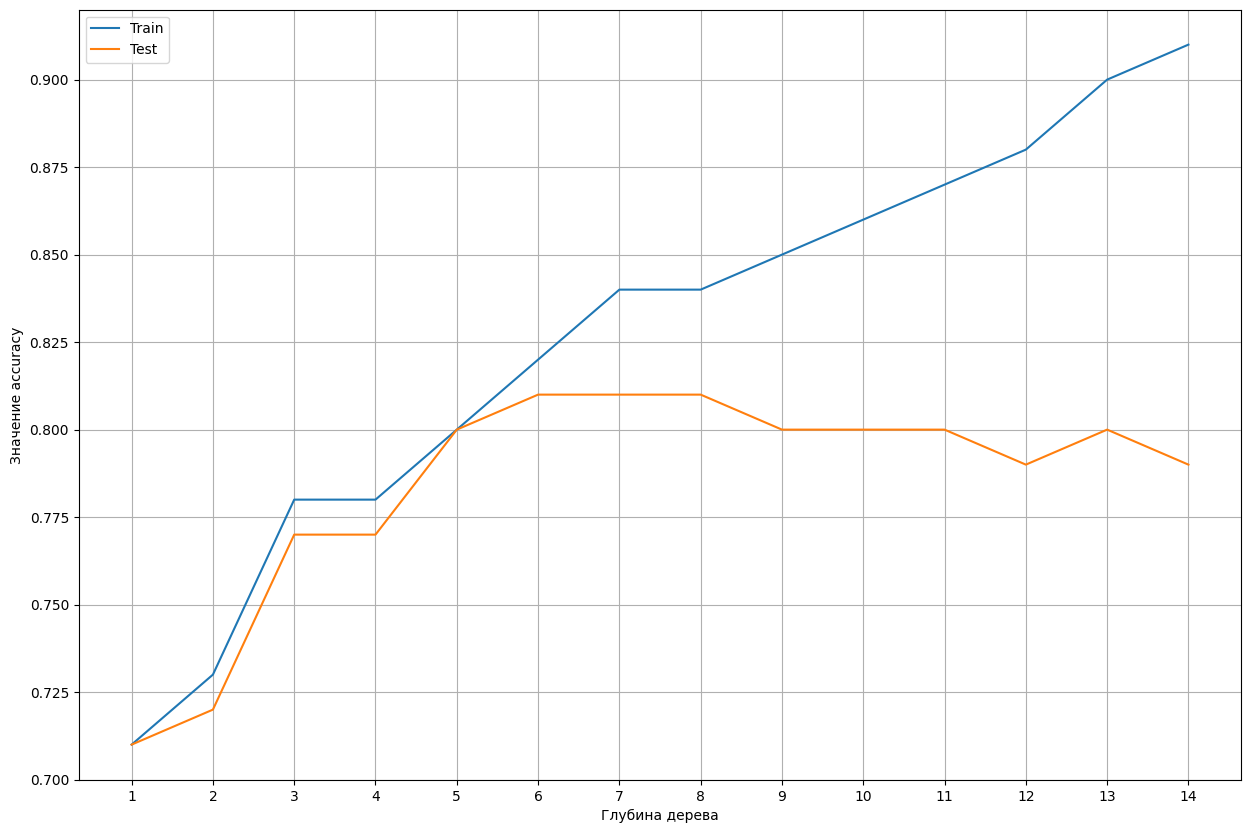

In [47]:
# Создадим пустые списки, в которые будем заносить значения метрики accuracy:
accuracy_train = []
accurasy_test = []

# Создадим цикл для перебора значений для max_depth:
for i in range(1, 15):
    dtc = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth=i)
    
    # Обучим модель:
    dtc.fit(X_train_scaled, y_train)
    # Сделаем предсказание:
    y_pred_test = dtc.predict(X_test_scaled)
    y_pred_train = dtc.predict(X_train_scaled)
    # Заносим результаты метрики в словари
    accuracy_train.append(round(metrics.accuracy_score(y_train, y_pred_train), 2))
    accurasy_test.append(round(metrics.accuracy_score(y_test, y_pred_test), 2))
    
# Визуализируем результаты метрики accuracy
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(range(1, 15), accuracy_train, label='Train')
ax.plot(range(1, 15), accurasy_test, label='Test')
ax.set_xlabel('Глубина дерева')
ax.set_ylabel('Значение accuracy')
ax.xaxis.set_ticks(range(1, 15))
ax.grid()
ax.legend()

При max_depth = 6 наблюдаются расхождения метрики accuracy на тренировочной и тестовой выборках. Именно с этого момента начинается переобучение модели. Однако подбирать гиперпараметры вручную слишком затратно. Проведём автоматическую оптимизацию нашей модели.

Попробуем подобрать гиперпараметры при помощи метода GridSearchCV.

In [71]:
from sklearn.model_selection import GridSearchCV

parameters =  {'min_samples_split': [2, 5, 7, 10],
               'max_depth':[3,5,7]}

model_cv = GridSearchCV(tree.DecisionTreeClassifier(), 
                        parameters,
                        cv=3,
                        scoring=('f1'), 
                        return_train_score=True)

model_cv.fit(X_train_scaled, y_train)

y_test_pred = model_cv.predict(X_test_scaled)
print(f'f1_score на тестовом наборе: {round(metrics.f1_score(y_test, y_test_pred), 3)}')
print(f'accuracy на тестовом наборе: {round(metrics.accuracy_score(y_test, y_test_pred), 3)}')

f1_score на тестовом наборе: 0.806
accuracy на тестовом наборе: 0.818


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

Построим модель на основе случайного леса.

In [73]:
rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)
#Обучаем модель
rf.fit(X_train_scaled, y_train)

# Предсказываем результат:
y_pred = rf.predict(X_test_scaled)
# Выодим метрики:
print(f'f1_score на тестовом наборе: {round(metrics.f1_score(y_test, y_pred), 3)}')
print(f'accuracy на тестовом наборе: {round(metrics.accuracy_score(y_test, y_pred), 3)}')

f1_score на тестовом наборе: 0.817
accuracy на тестовом наборе: 0.828


Метрики незначительно улучшились.

Попробуем построить модель на основе градиентного бустинга.

In [74]:
gb = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)
gb.fit(X_train_scaled, y_train)

# Выводим метрики:
y_pred = gb.predict(X_test_scaled)
print(f'f1_score на тестовом наборе: {round(metrics.f1_score(y_test, y_pred), 3)}')
print(f'accuracy на тестовом наборе: {round(metrics.accuracy_score(y_test, y_pred), 3)}')

f1_score на тестовом наборе: 0.816
accuracy на тестовом наборе: 0.826


Метрики не улучшились.

Попробуем использовать стекинг из решающих деревьев, логистической регрессии и градиентного бустинга. В качестве метамодели будем использовать модель логистической регрессии.

In [75]:
estimators = [
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=5,
        max_depth=6,
        random_state=42
        )
    ),
    ('log_reg', linear_model.LogisticRegression(
        solver='sag',
        random_state=42 
        )
    ),
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
        )
    )
]

stack = ensemble.StackingClassifier(
    estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)
stack.fit(X_train_scaled, y_train)

# Выводим метрики:
y_pred = stack.predict(X_test_scaled)
print(f'f1_score на тестовом наборе: {round(metrics.f1_score(y_test, y_pred), 3)}')
print(f'accuracy на тестовом наборе: {round(metrics.accuracy_score(y_test, y_pred), 3)}')

f1_score на тестовом наборе: 0.813
accuracy на тестовом наборе: 0.827


Метроики лучше не стали.

Попробуем настроить гиперпараметры методом Optuna.

In [77]:
# Настраиваем оптимизацию гиперпараметров:
random_state = 42
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  
  # обучаем модель
  score = cross_val_score(model, X, y, cv=5, scoring='f1', n_jobs=-1).mean()

  return score

# cоздаем объект исследования
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров
study.optimize(optuna_rf, n_trials=20)
# Выводим на экран лучшие гиперпараметры:
print(f'Наилучшие значения гиперпараметров: {study.best_params}')

[I 2023-10-06 20:03:10,414] A new study created in memory with name: RandomForestClassifier
[I 2023-10-06 20:03:19,770] Trial 0 finished with value: 0.7588321883007845 and parameters: {'n_estimators': 154, 'max_depth': 25, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.7588321883007845.
[I 2023-10-06 20:03:25,878] Trial 1 finished with value: 0.7545657892827797 and parameters: {'n_estimators': 193, 'max_depth': 14, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.7588321883007845.
[I 2023-10-06 20:03:31,437] Trial 2 finished with value: 0.7485884879470206 and parameters: {'n_estimators': 186, 'max_depth': 23, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.7588321883007845.
[I 2023-10-06 20:03:37,254] Trial 3 finished with value: 0.7487774618385614 and parameters: {'n_estimators': 183, 'max_depth': 26, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.7588321883007845.
[I 2023-10-06 20:03:43,153] Trial 4 finished with value: 0.7524594874053541 and parameters: {'n_

Наилучшие значения гиперпараметров: {'n_estimators': 137, 'max_depth': 21, 'min_samples_leaf': 2}


In [78]:
# Сделаем прогноз с подобранными гиперпараметрами:
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
print(f'f1_score на тестовом наборе: {round(metrics.f1_score(y_test, y_pred), 3)}')
print(f'accuracy на тестовом наборе: {round(metrics.accuracy_score(y_test, y_pred), 3)}')

f1_score на тестовом наборе: 0.822
accuracy на тестовом наборе: 0.831


Это лучший результат, который нам удалось получить.

# Вывод по проекту.

Наилучшим образом с задачей классификации на предоставленном наборе данных справляется модель случайного леса со следующими гиперпараметрами:
* 'n_estimators': 137,
* 'max_depth': 21,
* 'min_samples_leaf': 2

Данная модель предсказывает результат с точность 83,1%. Метрика F1 на тестовом наборе равна 0.822.